In [1]:
import pandas as pd
import numpy as np

cohort = pd.read_csv("/Users/burke/Documents/research/bpCog/combinedCohort.csv", low_memory=False)
cohort = cohort[['newid', 'visitcounter', 'SBP', 'DBP', 'bmi', 'trig', 'Smokestatus', 'choltot', 'cholhdl', 'cholldl', 
                 'age0', 'female0', 'educ0', 'daysfromvisit1', 'racebpcog', 'hba1c', 'glucosef', 'educ0', 'physact', 'waistcm']]

cohort['newid'] = cohort['newid'].str[2:]
cohort['newid'] = cohort['newid'].str[:-1]

cohort = cohort.assign(id=(cohort['newid']).astype('category').cat.codes)
cohort.drop(labels=['newid'], axis='columns', inplace=True)

cohort.rename(columns={'SBP' : 'sbp', 'DBP' : 'dbp', 'Smokestatus' : 'smokingStatus', 'choltot' : 'totChol',
                      "cholhdl" : 'hdl', 'cholldl' : 'ldl', 'age0' : 'baseAge', 'female0' : 'gender', 'educ0' : 'education',
                      'hba1c' : 'a1c', 'racebpcog' : 'raceEthnicity', 'waistcm' : 'waist', 'physact' : 'anyPhysicalActivity'}, inplace=True)

cohort.gender.replace(to_replace=[0,1], value=[1, 2], inplace=True)
# have to compress "hispanic" to "other hispanic" and no representation for mexican american in BP Cog
cohort.raceEthnicity.replace(to_replace=[1,2,3,9], value=[4,3,2,5], inplace=True)

In [3]:
cohort.describe()

,visitcounter,sbp,dbp,bmi,trig,smokingStatus,totChol,hdl,ldl,baseAge,gender,education,daysfromvisit1,raceEthnicity,a1c,glucosef,education,anyPhysicalActivity,waist,id
count,280786.000000,206364.000000,206331.000000,179325.000000,174142.000000,188549.000000,192742.000000,174008.000000,171928.000000,280786.000000,280786.000000,241683.000000,280786.000000,280786.000000,41246.000000,147443.000000,241683.000000,119458.000000,145712.000000,280786.000000
mean,5.378071,133.442421,80.145498,27.748416,122.992064,0.726495,197.002103,52.280423,120.046370,54.048200,0.567357,3.350538,3483.219149,2.050131,5.794838,103.760943,3.350538,0.889400,95.611963,17521.462366
std,4.258441,20.528950,15.391949,5.663701,87.927072,0.760151,40.069595,16.242849,36.174147,17.979592,0.495443,1.381541,3421.068771,1.144356,0.954149,34.502286,1.381541,0.313637,15.572090,11141.994822
min,1.000000,52.000000,0.000000,4.536454,8.000000,0.000000,50.000000,4.000000,0.000000,5.000000,0.000000,1.000000,-47.000000,1.000000,1.720000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,119.300000,69.000000,23.832836,71.000000,0.000000,170.000000,41.000000,95.000000,44.000000,0.000000,2.000000,984.000000,2.000000,5.300000,88.000000,2.000000,1.000000,85.000000,8266.000000
50%,4.000000,132.000000,79.300000,26.876138,102.000000,1.000000,194.000000,50.000000,117.800000,57.000000,1.000000,3.000000,2241.000000,2.000000,5.600000,96.000000,3.000000,1.000000,95.000000,16731.000000
75%,7.000000,145.300000,91.000000,30.612566,149.000000,1.000000,221.000000,61.000000,142.000000,68.000000,1.000000,5.000000,5521.000000,2.000000,6.000000,106.000000,5.000000,1.000000,105.000000,25117.000000
max,29.000000,284.000000,180.000000,136.926011,5329.000000,2.000000,885.000000,249.000000,504.600000,107.000000,1.000000,5.000000,33006.000000,9.000000,20.100000,712.000000,5.000000,1.000000,360.000000,41162.000000


In [4]:
allFactorsImputation = ["a1c", "hdl", "totChol", "bmi", "dbp", "sbp", "ldl", "trig", "glucosef", "waist", "anyPhysicalActivity"]

lagVars = []

# first geneate lag variables which we'll use in teh imputatino
for factor in allFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    lagVars.append(newVarName)
    cohort[newVarName] = cohort.groupby(['id'])[factor].shift(1)
    cohort = cohort.join(other=cohort.groupby(['id'])[newVarName].mean(), on='id', rsuffix='mean')
    cohort.rename(columns={newVarName + "mean" : 'mean' + newVarName[0].upper() + newVarName[1:]}, inplace=True)
cohort.drop(lagVars, axis='columns', inplace=True)

cohort['age'] = cohort.baseAge + cohort.daysfromvisit1 / 365
cohort = pd.concat([cohort, pd.get_dummies(cohort['raceEthnicity'], prefix="raceEth")], axis=1)
cohort = pd.concat([cohort, pd.get_dummies(cohort['smokingStatus'], prefix="smoke")], axis=1)
cohort = pd.concat([cohort, pd.get_dummies(cohort['education'], prefix="educ")], axis=1)


cohort.drop(['baseAge', 'daysfromvisit1', 'visitcounter', 'smokingStatus', 'raceEthnicity', 'education'], axis='columns', inplace=True)

cohort.rename(columns={'raceEth_2.0' : 'raceEth2', 'raceEth_3.0' : 'raceEth3', 'raceEth_4.0' : 'raceEth4',
                        'raceEth_5.0' : 'raceEth5', 'smoke_0.0' : 'smoke0', 'smoke_1.0' : 'smoke1' , 
                       'smoke_2.0' : 'smoke2', 'educ_1.0' : 'educ1', 'educ_2.0' : 'educ2', 'educ_3.0' : 'educ3',
                      'educ_4.0' : 'educ4', 'educ_5.0' : 'educ5'}, inplace=True)


In [5]:
import statsmodels.imputation.mice as mice

def getFormulaForVariable(var):
    cols = list(cohort.columns)
    cols.remove(var)
    colStrings = [col + "+"for col in cols]
    return "".join(colStrings)[:-1]
    
imputedCohort = mice.MICEData(cohort)
binaryVars = ['smoke0', 'smoke1', 'smoke2', 'raceEth2', 'raceEth3', 'raceEth4', 'raceEth5', 'educ1', 'educ2', 'educ3', 'educ4', 'educ5']
for var in binaryVars: 
    imputedCohort.set_imputer(var, formula=getFormulaForVariable(var), model_class="logit")
imputedCohort.update_all(20)

ValueError: list.remove(x): x not in list

In [4]:
imputedCohort.results['a1c'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     8796.
Date:                Tue, 27 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:48:51   Log-Likelihood:                -17834.
No. Observations:               41246   AIC:                         3.572e+04
Df Residuals:                   41219   BIC:                         3.595e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3922      0.024     16.556      0.000       0.346       0.439
x1            -0.0004      0.000     -2.227      0.026      -0.001   -4.66e-05
x2             0.0015      0.000      5.398      0.000       0.001       0.002
x3             0.0124      0.001     16.591      0.000       0.011       0.014
x4            -0.0001      0.000     -0.432      0.666      -0.001       0.000
x5            -0.0003      0.001     -0.234      0.815      -0.003       0.002
x6             0.0007      0.001      0.548      0.584      -0.002       0.003
x7             0.0001      0.001      0.104      0.917      -0.002       0.003
x8             0.0125      0.004      3.253      0.001       0.005       0.020
x9             0.0134   9.92e-05    134.875      0.000       0.013       0.014
x10         -1.82e-06   2.25e-07     -8.089      0.000   -2.26e-06   -1.38e-06
x11            0.8260      0.003    275.353      0.000       0.820       0.832
x12           -0.0018      0.001     -3.110      0.002      -0.003      -0.001
x13            0.0011      0.001      2.141      0.032    9.44e-05       0.002
x14           -0.0123      0.001    -14.189      0.000      -0.014      -0.011
x15           -0.0020      0.000     -6.644      0.000      -0.003      -0.001
x16           -0.0007      0.000     -3.090      0.002      -0.001      -0.000
x17           -0.0012      0.001     -2.297      0.022      -0.002      -0.000
x18        -1.763e-05   9.86e-05     -0.179      0.858      -0.000       0.000
x19           -0.0098      0.000    -66.335      0.000      -0.010      -0.009
x20            0.0061      0.000     27.458      0.000       0.006       0.007
x21            0.1196      0.009     13.963      0.000       0.103       0.136
x22            0.0425      0.007      6.213      0.000       0.029       0.056
x23            0.1091      0.008     13.143      0.000       0.093       0.125
x24            0.1210      0.010     11.913      0.000       0.101       0.141
x25           -0.0117      0.005     -2.232      0.026      -0.022      -0.001
x26           -0.0098      0.005     -1.801      0.072      -0.020       0.001
x27            0.0059      0.007      0.804      0.421      -0.008       0.020
==============================================================================
Omnibus:                    19309.284   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1405847.065
Skew:                           1.400   Prob(JB):                         0.00
Kurtosis:                      31.464   Cond. No.                     2.55e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.57e-18. This might indic

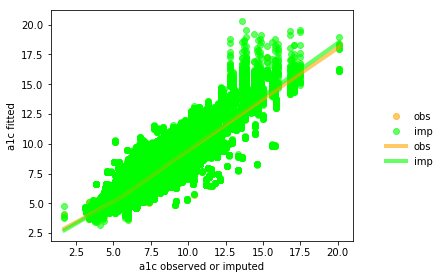

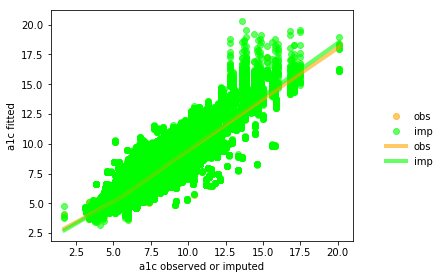

In [5]:
%matplotlib inline
imputedCohort.plot_fit_obs("a1c")

In [6]:
imputedData = imputedCohort.data.copy()

# rebvuild categoricals
imputedData['smokingStatus'] = imputedData[['smoke0', 'smoke1', 'smoke2']].idxmax(axis=1)
imputedData['smokingStatus'] = imputedData['smokingStatus'].str[-1:]
imputedData['raceEthnicity'] = imputedData[['raceEth2', 'raceEth3', 'raceEth4', 'raceEth5']].idxmax(axis=1)
imputedData['raceEthnicity'] = imputedData['raceEthnicity'].str[-1:]


In [7]:
# drop the dummies
imputedData.drop(['smoke0', 'smoke1','smoke2'], axis='columns', inplace=True)
imputedData.drop(['raceEth2', 'raceEth3','raceEth3', 'raceEth4', 'raceEth5'], axis='columns', inplace=True)


# drop the mean variables (they were partially imputed)
imputedData.drop(list(imputedData.filter(regex='mean')), axis='columns', inplace=True)


# rebuild the mean variables off the impuated values
allFactorsImputation = ["a1c", "hdl", "totChol", "bmi","ldl", "trig", "glucosef"]
logFactorsImputation = ["dbp", "sbp"]

In [8]:
for factor in allFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    imputedData[newVarName] = imputedData.groupby(['id'])[factor].shift(1)
    imputedData = imputedData.join(other=imputedData.groupby(['id'])[newVarName].mean(), on='id', rsuffix='mean')
    imputedData.rename(columns={newVarName + "mean" : 'mean' + newVarName[0].upper() + newVarName[1:]}, inplace=True)

In [9]:
for factor in logFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    imputedData[newVarName] = imputedData.groupby(['id'])[factor].shift(1)
    logLagName = "log" + newVarName[0].upper() + newVarName[1:]
    logName = "log" + factor[0].upper() + factor[1:]

    imputedData[logName] = np.log(imputedData[factor])  
    imputedData[logLagName] = np.log(imputedData[newVarName])  
    imputedData = imputedData.join(other=imputedData.groupby(['id'])[logLagName].mean(), on='id', rsuffix='mean')
    imputedData.rename(columns={logLagName + "mean" : 'mean' + logLagName[0].upper() + logLagName[1:]}, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [10]:
imputedData.raceEthnicity= imputedData.raceEthnicity.astype('category')
imputedData.smokingStatus= imputedData.smokingStatus.astype('category')
imputedData.sort_values(by=['id', 'age'], inplace=True)

In [11]:
imputedData.raceEthnicity.value_counts()



3    177722
4     61078
2     36458
5      5528
Name: raceEthnicity, dtype: int64

In [12]:
import statsmodels.formula.api as statsmodel
import sys
import os
sys.path.append(os.path.abspath("../mcm/"))
from mcm.regression_model import RegressionModel

regResults = {}

def buildAndExportRegressionModelForDataset(outcomeVariable , fullDataset, hasLog): 
    factors = allFactors.copy()
    factors.extend(logFactors)
    factors.remove(outcomeVariable)
    factors = ["mean" + factor[0].upper() + factor[1:] + " + " + factor + " + " for factor in factors] 
    
    meanLagOutcomeVariable =  "mean" + outcomeVariable[0].upper() + outcomeVariable[1:]
    
    if (not hasLog):
        outcomeVariable = outcomeVariable[3:4].lower() + outcomeVariable[4:] # remove the lag
    else:
        outcomeVariable = "log" + outcomeVariable[-3:] # remove the lag and add the log
    
    formula = outcomeVariable + " ~ " + "".join(factors) + "age + gender + smokingStatus + raceEthnicity + " + meanLagOutcomeVariable

    print("outcome: " + outcomeVariable + " hasLog: " + str(hasLog) + " : " +formula)

    model = statsmodel.ols(formula=formula, data=fullDataset)
    results = model.fit()
    regResults[outcomeVariable] = results
    mcmRegressionModel = RegressionModel(results.params.to_dict(), results.bse.to_dict(), results.resid.mean(), results.resid.std())
    mcmRegressionModel.write_json(os.path.abspath("../mcm/mcm/data/" + outcomeVariable + "CohortModelSpec.json"))
    #results.save("/Users/burke/Documents/research/bpCog/mcm/mcm/data/" + outcomeVariable +  "CohortModel.pickle")
    return results


allFactors = ["lagA1c", "lagHdl", "lagTotChol", "lagBmi", "lagLdl", "lagTrig"]
logFactors = ["logLagDbp", "logLagSbp"]

imputedData['logDbp'].loc[imputedData['logDbp'] <= 0] = imputedData['logDbp'].loc[imputedData['logDbp']> 0].min()
imputedData['logLagDbp'].loc[imputedData['logLagDbp'] <= 0] = imputedData['logLagDbp'].loc[imputedData['logLagDbp']> 0].min()
imputedData['meanLogLagDbp'].loc[imputedData['meanLogLagDbp'] <= 0] = imputedData['meanLogLagDbp'].loc[imputedData['meanLogLagDbp']> 0].min()



for factor in allFactors:
    buildAndExportRegressionModelForDataset(factor, imputedData, False)
for factor in logFactors:
    buildAndExportRegressionModelForDataset(factor, imputedData, True)
    

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


outcome: a1c hasLog: False : a1c ~ meanLagHdl + lagHdl + meanLagTotChol + lagTotChol + meanLagBmi + lagBmi + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLogLagDbp + logLagDbp + meanLogLagSbp + logLagSbp + age + gender + smokingStatus + raceEthnicity + meanLagA1c
outcome: hdl hasLog: False : hdl ~ meanLagA1c + lagA1c + meanLagTotChol + lagTotChol + meanLagBmi + lagBmi + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLogLagDbp + logLagDbp + meanLogLagSbp + logLagSbp + age + gender + smokingStatus + raceEthnicity + meanLagHdl
outcome: totChol hasLog: False : totChol ~ meanLagA1c + lagA1c + meanLagHdl + lagHdl + meanLagBmi + lagBmi + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLogLagDbp + logLagDbp + meanLogLagSbp + logLagSbp + age + gender + smokingStatus + raceEthnicity + meanLagTotChol
outcome: bmi hasLog: False : bmi ~ meanLagA1c + lagA1c + meanLagHdl + lagHdl + meanLagTotChol + lagTotChol + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLogLagDbp + logLagDbp + meanLo

In [ ]:
type(regResults['logSbp'].params)

In [13]:
regResults['logSbp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logSbp   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                 1.826e+04
Date:                Tue, 27 Nov 2018   Prob (F-statistic):               0.00
Time:                        09:49:05   Log-Likelihood:             2.2721e+05
No. Observations:              239623   AIC:                        -4.544e+05
Df Residuals:                  239600   BIC:                        -4.541e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1007      0.008     12.525      0.000       0.085       0.116
smokingStatus[T.1]     0.0028      0.000      5.686      0.000       0.002       0.004
smokingStatus[T.2]     0.0032      0.001      4.786      0.000       0.002       0.004
raceEthnicity[T.3]    -0.0030      0.001     -4.796      0.000      -0.004      -0.002
raceEthnicity[T.4]    -0.0042      0.001     -5.890      0.000      -0.006      -0.003
raceEthnicity[T.5]    -0.0009      0.002     -0.576      0.564      -0.004       0.002
meanLagA1c             0.0016      0.000      4.829      0.000       0.001       0.002
lagA1c              2.486e-05      0.000      0.092      0.926      -0.001       0.001
meanLagHdl          5.126e-05      0.000      0.376      0.707      -0.000       0.000
lagHdl              3.816e-06    6.6e-05      0.058      0.954      -0.000       0.000
meanLagTotChol     -6.241e-05      0.000     -0.467      0.641      -0.000       0.000
lagTotChol          7.934e-05   6.02e-05      1.319      0.187   -3.86e-05       0.000
meanLagBmi             0.0009      0.000      7.992      0.000       0.001       0.001
lagBmi                -0.0011      0.000    -10.419      0.000      -0.001      -0.001
meanLagLdl             0.0001      0.000      0.780      0.436      -0.000       0.000
lagLdl             -3.339e-05   6.01e-05     -0.556      0.578      -0.000    8.44e-05
meanLagTrig         1.158e-05   2.54e-05      0.456      0.648   -3.82e-05    6.13e-05
lagTrig            -4.611e-06   1.09e-05     -0.424      0.672   -2.59e-05    1.67e-05
meanLogLagDbp         -0.0113      0.002     -5.921      0.000      -0.015      -0.008
logLagDbp              0.0013      0.002      0.846      0.398      -0.002       0.004
age                   -0.0002    1.7e-05     -9.981      0.000      -0.000      -0.000
gender                 0.0022      0.000      5.223      0.000       0.001       0.003
meanLogLagSbp          0.9865      0.002    475.573      0.000       0.982       0.991
==============================================================================
Omnibus:                     9788.234   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27976.118
Skew:                          -0.156   Prob(JB):                         0.00
Kurtosis:                       4.644   Cond. No.                     1.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
imputedData.logLagDbp.describe()

ok...mdels are looking a bit bette rnow. sbp model looks reasonbly close to stata model which is reassureing.

other thought...
if we systematically name the variables here, it may be relatively easy to build a risk model apparatus that reads from these files and implements them. so, "log" means that the predictor is log-transformed. "meanLab" means that you take the maen of all prior values. "lag" means that you take the the value immediately before.

then you can include variable names in snake case — so each variable is multiple in. you'd be able to specify multi-way interactions or quadratic terms pretty easily that way... 